Project: Het voorspellen van het COVID-19 virus in Nederland. | Student: Timo Vossen | Studentnummer: 1683452 | Datum: 30-03-2020 | Cursus: Data & AI | Opleiding: Communication and Multimedia Design | Docenten: Daan Oldenhof & Sam Verkoelen

# Importeer lijst

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sp
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

# Dataframe aanmaken
CSV bestanden van de 'Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE' GitHub pagina scrapen en in een DataFrame zetten.

In [2]:
url = requests.get('https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports')
html = BeautifulSoup(url.text, 'html.parser')
results = html.find_all('td', attrs={'class' : 'content'})
corona_links = pd.DataFrame()
all_files1 = pd.DataFrame()
all_files2 = pd.DataFrame()
for links in html.findAll('a', href=True):
    link = links['href']
    corona_links = corona_links.append({'link': link}, ignore_index=True)
corona_links_select = corona_links[corona_links['link'].str.contains(".csv", na=False)]

#op 22 maart zijn ze hun datasets anders gaan invullen. Hierdoor moet ik op twee verschillende manieren de data importeren.
corona_links_select1 = corona_links_select[0:60]
corona_links_select2 = corona_links_select[60:]

In [3]:
#dit zijn alle CSV bestanden, voor 22 maart in het oude format
for csv_url1 in corona_links_select1['link']:
    url_file1 = 'https://github.com'+csv_url1
    request_file1 = requests.get(url_file1)
    html_file1 = BeautifulSoup(request_file1.text, 'html.parser')
    for raw1 in html_file1.findAll('a', attrs={'id' : 'raw-url'}, href=True):
        raw_link1 = 'https://github.com'+raw1['href']
    all_files1 = all_files1.append({'link': raw_link1}, ignore_index=True)
df_from_each_file1 = (pd.read_csv(f) for f in all_files1['link'])
data1 = pd.concat(df_from_each_file1, ignore_index=True, sort=False)
data1

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Anhui,Mainland China,1/22/2020 17:00,1.0,NaN,NaN,NaN,NaN
1,Beijing,Mainland China,1/22/2020 17:00,14.0,NaN,NaN,NaN,NaN
2,Chongqing,Mainland China,1/22/2020 17:00,6.0,NaN,NaN,NaN,NaN
3,Fujian,Mainland China,1/22/2020 17:00,1.0,NaN,NaN,NaN,NaN
4,Gansu,Mainland China,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7612,NaN,Jersey,2020-03-17T18:33:03,0.0,0.0,0.0,49.1900,-2.110
7613,NaN,Puerto Rico,2020-03-17T16:13:14,0.0,0.0,0.0,18.2000,-66.500
7614,NaN,Republic of the Congo,2020-03-17T21:33:03,0.0,0.0,0.0,-1.4400,15.556
7615,NaN,The Bahamas,2020-03-19T12:13:38,0.0,0.0,0.0,24.2500,-76.000


In [4]:
#dit zijn alle CSV bestanden, na 22 maart in het nieuwe format
for csv_url2 in corona_links_select2['link']:
    url_file2 = 'https://github.com'+csv_url2
    request_file2 = requests.get(url_file2)
    html_file2 = BeautifulSoup(request_file2.text, 'html.parser')
    for raw2 in html_file2.findAll('a', attrs={'id' : 'raw-url'}, href=True):
        raw_link2 = 'https://github.com'+raw2['href']
    all_files2 = all_files2.append({'link': raw_link2}, ignore_index=True)
df_from_each_file2 = (pd.read_csv(f) for f in all_files2['link'])
data2 = pd.concat(df_from_each_file2, ignore_index=True, sort=False)
data2

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
27378,NaN,NaN,NaN,Venezuela,2020-03-29 23:08:13,6.423800,-66.589700,119,2,39,78,Venezuela
27379,NaN,NaN,NaN,Vietnam,2020-03-29 23:08:13,14.058324,108.277199,188,0,25,163,Vietnam
27380,NaN,NaN,NaN,West Bank and Gaza,2020-03-29 23:08:13,31.952200,35.233200,109,1,18,90,West Bank and Gaza
27381,NaN,NaN,NaN,Zambia,2020-03-29 23:08:13,-13.133897,27.849332,29,0,0,29,Zambia


Data opschonen en DataFrame klaar maken voor gebruik.

In [5]:
df2 = data2.copy()
df2 = df2.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region' , 'Last_Update': 'Last Update', 'Lat': 'Latitude', 'Long_': 'Longitude'})
df2 = df2.drop(['FIPS','Admin2', 'Active', 'Combined_Key'], axis=1)
df2 = df2[['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered', 'Latitude', 'Longitude']]
df = pd.concat([data1, df2])
#df = data.copy()
df = df.rename(columns={'Country/Region': 'Region', 'Last Update': 'Date' , 'Province/State': 'Province'})
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Confirmed'] = df['Confirmed'].fillna(0)
df['Deaths'] = df['Deaths'].fillna(0)
df['Recovered'] = df['Recovered'].fillna(0)
df['Province'] = df['Province'].fillna(0)
for index, row in df.iterrows():
    if row['Province'] != 0:
        province = row['Province']
        df['Region'] = np.where((df.Province != 0) & (df.Province == row['Province']),province,df.Region)
    else:
        pass
df = df.drop(['Province','Latitude', 'Longitude'], axis=1)
df = df.drop_duplicates(subset=['Region', 'Date'], keep='last')
df

,Region,Date,Confirmed,Deaths,Recovered
0,Anhui,2020-01-22,1.0,0.0,0.0
1,Beijing,2020-01-22,14.0,0.0,0.0
2,Chongqing,2020-01-22,6.0,0.0,0.0
3,Fujian,2020-01-22,1.0,0.0,0.0
4,Gansu,2020-01-22,0.0,0.0,0.0
...,...,...,...,...,...
27378,Venezuela,2020-03-29,119.0,2.0,39.0
27379,Vietnam,2020-03-29,188.0,0.0,25.0
27380,West Bank and Gaza,2020-03-29,109.0,1.0,18.0
27381,Zambia,2020-03-29,29.0,0.0,0.0


Als back-up methode kan je hier het recent opgeslagen csv bestand openen ipv de webscrape methode van hierboven.

In [6]:
#df = pd.read_csv('COVID-19_25_03_2020.csv', encoding='latin-1')
#df

# Virus vs populatie
In dit gedeelte van het notebook wilde ik gaan kijken hoeveel mensen er in een gebied besmet of overleden waren in procenten.
##### Hieronder kan je een aantal parameters instellen:

Land = voor welk land wil je een voorspelling doen? (bijvoorbeeld 'Netherlands' of 'Italy')

In [7]:
Land = 'Italy'

Dataset inladen van de UN met daarin hoeveel mensen er in bepaalde landen wonen.

In [8]:
population = pd.read_csv('population_estimates.csv', encoding='latin-1')
population.columns = [c.replace(' ', '_') for c in population.columns]
population.columns = [c.replace(',', '') for c in population.columns]
population.columns = [c.replace('*', '') for c in population.columns]
population

,Index,Variant,Region_subregion_country_or_area_,Notes,Country_code,Type,Parent_code,1950,1951,1952,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,1,Estimates,WORLD,NaN,900,World,0,2536431.018,2584034.227,2630861.69,...,7041194.16799999,7125827.957,7210582.041,7295290.759,7379796.967,7464021.934,7547858.9,7631091.113,7713468.20500001,7794798.729
1,2,Estimates,UN development groups,a,1803,Label/Separator,900,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,3,Estimates,More developed regions,b,901,Development Group,1803,814818.913,824003.512,833720.173,...,1239557.448,1244114.531,1248453.53,1252615.112,1256622.188,1260478.667,1264146.38,1267558.904,1270630.32,1273304.261
3,4,Estimates,Less developed regions,c,902,Development Group,1803,1721612.105,1760030.715,1797141.517,...,5801636.72,5881713.426,5962128.511,6042675.647,6123174.779,6203543.267,6283712.52,6363532.20899999,6442837.88500001,6521494.468
4,5,Estimates,Least developed countries,d,941,Development Group,902,195427.785,199180.385,203015.198,...,856471.437,876867.234,897793.439,919222.955,941131.317000001,963519.718,986385.402,1009691.252,1033388.868,1057438.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,285,Estimates,Bermuda,14,60,Country/Area,918,37.256,37.8,38.437,...,65.076,64.737,64.381,64.038,63.695,63.36,63.04,62.763,62.508,62.273
285,286,Estimates,Canada,NaN,124,Country/Area,918,13733.398,14078.449,14445.453,...,34539.156,34922.031,35296.535,35664.338,36026.668,36382.942,36732.091,37074.558,37411.038,37742.157
286,287,Estimates,Greenland,26,304,Country/Area,918,22.993,23.466,23.936,...,56.555,56.477,56.412,56.383,56.378,56.408,56.473,56.565,56.66,56.772
287,288,Estimates,Saint Pierre and Miquelon,2,666,Country/Area,918,4.567,4.609,4.648,...,6.323,6.251,6.168,6.073,5.992,5.933,5.885,5.845,5.821,5.795


De relevante data selecteren van het gekozen land.

In [9]:
population_select = population.loc[population['Region_subregion_country_or_area_'] == Land]
population_select = population_select.drop('Variant', axis=1)
population_select = population_select.drop('Region_subregion_country_or_area_', axis=1)
population_select = population_select.drop('Country_code', axis=1)
population_select = population_select.drop('Type', axis=1)
population_select = population_select.drop('Parent_code', axis=1)
population_select = population_select.drop('Index', axis=1)
population_select = population_select.drop('Notes', axis=1)
population_select = population_select.T
df_pop = population_select.copy().reset_index()
df_pop.columns = ['year', 'population']
df_pop.population = df_pop.population.astype(float)
df_pop['population'] = df_pop['population'].apply(lambda x: x*1000)
df_pop

,year,population
0,1950,46598599.0
1,1951,47009982.0
2,1952,47390571.0
3,1953,47737391.0
4,1954,48051041.0
...,...,...
66,2016,60663068.0
67,2017,60673694.0
68,2018,60627291.0
69,2019,60550092.0


In [10]:
pop_select_year = df_pop.loc[df_pop['year'] == '2020']
pop_select = pop_select_year.iloc[0]['population']
print('Aantal inwoners in', Land, 'in het jaar', '2020', 'is:', pop_select)

Aantal inwoners in Italy in het jaar 2020 is: 60461828.0


In [11]:
df_selection = df.loc[df['Region'] == Land]
df_select_sick = df_selection.max()
Confirmed_select = df_select_sick['Confirmed']
Deaths_select = df_select_sick['Deaths']
Recovered_select = df_select_sick['Recovered']
sick_total = Confirmed_select+Deaths_select+Recovered_select
print('Op dit moment zijn er', sick_total, 'bekende coronavirus gevallen in Nederland')

Op dit moment zijn er 121498.0 bekende coronavirus gevallen in Nederland


Hieronder wilde ik in een pie-chart laten zien hoeveel procent van het geselecteerde land besmet is geweest en hoeveel nog niet. Waar ik echter achter kwam was dat dit zo'n klein aantal is, waardoor het niet/bijna niet zichtbaar wordt in de chart.

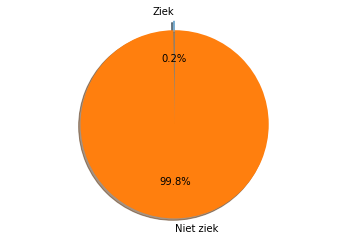

In [12]:
A = 100*sick_total/pop_select
B = 100*(pop_select-sick_total)/pop_select

labels = 'Ziek', 'Niet ziek'
A = 100*sick_total/pop_select
B = 100*(pop_select-sick_total)/pop_select
sizes = [A, B]
explode = (0, 0.1)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Neuraal netwerk
In dit gedeelte van het notebook heb ik geprobeert om een neuraal netwerk te maken dat aan de hand van de bekende data een voorspelling doet voor het aantal besmette mensen met het coronavirus.

In [13]:
df_ML = df.copy()
df_ML['Region_code'] = pd.factorize(df_ML['Region'])[0] + 1
df_ML_min = df_ML.copy()
df_ML_min = df_ML_min.drop(['Date', 'Region'], axis=1)
df_ML_min

,Confirmed,Deaths,Recovered,Region_code
0,1.0,0.0,0.0,1
1,14.0,0.0,0.0,2
2,6.0,0.0,0.0,3
3,1.0,0.0,0.0,4
4,0.0,0.0,0.0,5
...,...,...,...,...
27378,119.0,2.0,39.0,394
27379,188.0,0.0,25.0,42
27380,109.0,1.0,18.0,482
27381,29.0,0.0,0.0,427


In [14]:
train_size = int(len(df_ML_min) * 0.8)
test_size = len(df_ML_min) - train_size
train, test = df_ML_min.iloc[0:train_size], df_ML_min.iloc[train_size:len(df_ML_min)]
print(len(train), len(test))
train

5631 1408


,Confirmed,Deaths,Recovered,Region_code
0,1.0,0.0,0.0,1
1,14.0,0.0,0.0,2
2,6.0,0.0,0.0,3
3,1.0,0.0,0.0,4
4,0.0,0.0,0.0,5
...,...,...,...,...
13395,0.0,0.0,0.0,338
13397,0.0,0.0,0.0,294
13399,3.0,0.0,0.0,343
13400,0.0,0.0,0.0,332


In [15]:
f_columns = ['Region_code','Deaths','Recovered']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['Confirmed']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Confirmed'] = cnt_transformer.transform(train[['Confirmed']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Confirmed'] = cnt_transformer.transform(test[['Confirmed']])
train

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Confirmed,Deaths,Recovered,Region_code
0,-0.191083,0.0,-0.047619,-0.339416
1,-0.135881,0.0,-0.047619,-0.335766
2,-0.169851,0.0,-0.047619,-0.332117
3,-0.191083,0.0,-0.047619,-0.328467
4,-0.195329,0.0,-0.047619,-0.324818
...,...,...,...,...
13395,-0.195329,0.0,-0.047619,0.890511
13397,-0.195329,0.0,-0.047619,0.729927
13399,-0.182590,0.0,-0.047619,0.908759
13400,-0.195329,0.0,-0.047619,0.868613


In [16]:
X_train = train.drop('Confirmed', axis=1)
y_train = train['Confirmed']
X_test = test.drop('Confirmed', axis=1)
y_test = test['Confirmed']
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [17]:
clf = MLPClassifier(hidden_layer_sizes=(3), solver='sgd', momentum=0.9, max_iter=200, learning_rate='adaptive', verbose=10)
#hidden layer sizes: aantal neuronene in een layer
#solver: 
#momentum: 
#max_iter: maximum aantal interaties
#learning rate: 
#verbose: wel of niet iteraties printen
#random state: 


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Iteration 1, loss = inf
Iteration 2, loss = 4.62087509
Iteration 3, loss = 4.09370323
Iteration 4, loss = 3.64769862
Iteration 5, loss = 3.13470463
Iteration 6, loss = 2.53035310
Iteration 7, loss = 1.92035569
Iteration 8, loss = 1.48523181
Iteration 9, loss = 1.26731310
Iteration 10, loss = 1.16853819
Iteration 11, loss = 1.11638532
Iteration 12, loss = 1.07817409
Iteration 13, loss = 1.05036289
Iteration 14, loss = 1.03056268
Iteration 15, loss = 1.01048069
Iteration 16, loss = 0.99878595
Iteration 17, loss = 0.97938907
Iteration 18, loss = 0.96419518
Iteration 19, loss = 0.95322252
Iteration 20, loss = 0.93664914
Iteration 21, loss = 0.92591986
Iteration 22, loss = 0.91396970
Iteration 23, loss = 0.90227718
Iteration 24, loss = 0.89824200
Iteration 25, loss = 0.88258594
Iteration 26, loss = 0.87457676
Iteration 27, loss = 0.86572743
Iteration 28, loss = 0.85739026
Iteration 29, loss = 0.84985161
Iteration 30, loss = 0.84257406
Iteration 31, loss = 0.83731598
Iteration 32, loss = 0.8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
accuracy_score(y_test, y_pred)

0.7308238636363636

In [19]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
uitkomst = test.copy()
uitkomst['y_pred'] = y_pred
uitkomst

,Confirmed,Deaths,Recovered,Region_code,y_pred
13402,-0.144374,0.0,-0.047619,0.879562,0
13405,-0.097665,0.0,-0.047619,0.989051,0
13406,-0.195329,0.0,-0.047619,0.817518,0
13407,-0.110403,0.0,-0.047619,0.762774,0
13408,-0.118896,0.0,-0.047619,0.781022,0
...,...,...,...,...,...
27378,0.309979,1.0,1.809524,1.094891,0
27379,0.602972,0.0,1.142857,-0.189781,0
27380,0.267516,0.5,0.809524,1.416058,0
27381,-0.072187,0.0,-0.047619,1.215328,0


In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(uitkomst)

        Confirmed  Deaths    Recovered  Region_code  y_pred
13402   -0.144374     0.0    -0.047619     0.879562       0
13405   -0.097665     0.0    -0.047619     0.989051       0
13406   -0.195329     0.0    -0.047619     0.817518       0
13407   -0.110403     0.0    -0.047619     0.762774       0
13408   -0.118896     0.0    -0.047619     0.781022       0
13409   -0.161359     0.5    -0.047619     0.788321       0
13411   -0.195329     0.0    -0.047619    -0.156934       0
13412   -0.195329     0.0    -0.047619     0.981752       0
13413   -0.182590     0.0    -0.047619    -0.153285       0
13414   -0.191083     0.0    -0.047619     0.744526       0
13416   -0.195329     0.0    -0.047619     0.759124       0
13417   -0.195329     0.0    -0.047619     0.886861       0
13418    1.324841     1.0    -0.047619     0.777372       0
13419   -0.195329     0.0    -0.047619     1.346715       0
13421   -0.123142     0.0     0.000000     1.058394       0
13422   -0.029724     0.0    -0.047619  

Na het maken van een neuraal netwerk op mijn data kam ik tot de conclusie dat ik veel meer verschillende data nodig zal hebben om dit goed te doen. Voorbeelden hiervan zijn: weer, infection rate, is een gebied in quarantaine, aantal vliegvelden, afstand tot China, verandering in aantal besmettingen van de afgelopen dagen, etc.

Ik ben niet meer verder gegaan met het verzamelen van deze data omdat dat niet was wat ik wilde bereiken. Ik wilde aan de hand van de data die ik nu had een voorspelling kunnen doen. Hierdoor ben ik dan ook gaan zoeken naar wiskundige modellen voor het berekenen van het verloop van een pandemie.

# SIR-model
In dit gedeelte van het notebook gaan we een voorspelling doen aan de hand van het SIR-model. SIR staat voor Susceptible, Infected en Recovered. Het SIr-model is het meest voor de hand liggende model om een pandemie te voorspellen.

##### Formules van het SIR model:
a = transmission coëfficient

b = recovery coëfficient

I'=aSI-bI

R'=bI

S'=-aSI

S(1) = S(0)+S'(0)1

I(1) = I(0)+I'(0)1

R(1) = R(0)+R'(0)1

##### Hieronder kan je een aantal parameters instellen:

Country = voor welk land wil je een voorspelling doen? (bijvoorbeeld 'Netherlands' of 'Italy')

Population = Hoeveel mensen wonen in het gebied en lopen daarmee een risico op besmetting? (Nederland=17134873 , Italy=60461828)


In [22]:
Country = 'Italy'
Population = 60461828

In [23]:
df_select2 = df.loc[df['Region'] == Country]
df_select2['Date_code'] = pd.factorize(df_select2['Date'])[0] + 1
df_select2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Region,Date,Confirmed,Deaths,Recovered,Date_code
885,Italy,2020-01-31,2.0,0.0,0.0,1
1916,Italy,2020-02-07,3.0,0.0,0.0,2
1979,Italy,2020-02-21,20.0,1.0,0.0,3
2060,Italy,2020-02-22,62.0,2.0,1.0,4
2132,Italy,2020-02-23,155.0,3.0,2.0,5
2215,Italy,2020-02-24,229.0,7.0,1.0,6
2301,Italy,2020-02-25,322.0,10.0,1.0,7
2393,Italy,2020-02-26,453.0,12.0,3.0,8
2490,Italy,2020-02-27,655.0,17.0,45.0,9
2593,Italy,2020-02-28,888.0,21.0,46.0,10


Mijn logica was dat om de transmission coëfficient en de recovery coëfficient te berekenen ik naar de correlatie tussen bepaalde columns moest gaan kijken.

           Confirmed    Deaths  Recovered  Date_code
Confirmed   1.000000  0.994392   0.994378   0.906594
Deaths      0.994392  1.000000   0.999124   0.870999
Recovered   0.994378  0.999124   1.000000   0.875860
Date_code   0.906594  0.870999   0.875860   1.000000


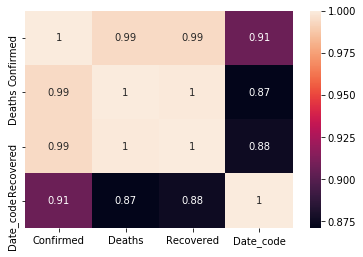

In [24]:
corr_matrix = df_select2.corr(method="pearson")
sn.heatmap(corr_matrix, annot=True)
print (corr_matrix)

Dit was dan ook hoe ik deze twee coëfficienten berekende.

In [25]:
a = df_select2['Date_code'].corr(df_select2['Confirmed'])
b = df_select2['Date_code'].corr(df_select2['Recovered'])
print('Transmission coëfficient (a) =', a)
print('Recovery coëfficient (b) =', b)

Transmission coëfficient (a) = 0.9065938850243155
Recovery coëfficient (b) = 0.8758599410536323


###### SIR-model uitvoeren
Als eerst selecteerde ik alle waarde die bij de eerste geregistreerde datum hoorde om zo vooruit te kunnen rekenen. Dit leek mij handig omdat ik dan de uitkomst kon controleren met de al bestaande data van die dagen.

In [26]:
SIR = pd.DataFrame()
i = df_select2['Confirmed'].iloc[0]
r = df_select2['Recovered'].iloc[0]
s = Population - r - i
s_prime = -a*s*i
i_prime = (a*s*i)-(b*i)
r_prime = b*i
SIR = SIR.append({'susceptible': s, 'infected': i, 'recovered': r, 's_prime': s_prime, 'i_prime': i_prime, 'r_prime': r_prime, 'day_code': 1}, ignore_index=True)
SIR = SIR[['day_code', 'susceptible', 'infected', 'recovered', 's_prime', 'i_prime', 'r_prime']]
SIR

,day_code,susceptible,infected,recovered,s_prime,i_prime,r_prime
0,1.0,60461826.0,2.0,0.0,-1.096286e+08,1.096286e+08,1.75172


Dit is de berekening van het SIR-model.

In [27]:
y = 5
d = SIR['day_code'].iloc[-1]
while d < y:
    d += 1
    if (d > y):
        break
    s = SIR['susceptible'].iloc[-1] + SIR['s_prime'].iloc[-1]
    i = SIR['infected'].iloc[-1] + SIR['i_prime'].iloc[-1]
    r = SIR['recovered'].iloc[-1] + SIR['r_prime'].iloc[-1]
    s_prime = -a*s*i
    i_prime = (a*s*i)-(b*i)
    r_prime = b*i
    SIR = SIR.append({'susceptible': s, 'infected': i, 'recovered': r, 's_prime': s_prime, 'i_prime': i_prime, 'r_prime': r_prime, 'day_code': d}, ignore_index=True)

In [28]:
SIR

,day_code,susceptible,infected,recovered,s_prime,i_prime,r_prime
0,1.0,6.046183e+07,2.000000e+00,0.000000e+00,-1.096286e+08,1.096286e+08,1.751720e+00
1,2.0,-4.916682e+07,1.096286e+08,1.751720e+00,4.886624e+15,-4.886624e+15,9.601934e+07
2,3.0,4.886624e+15,-4.886624e+15,9.601934e+07,2.164864e+31,-2.164864e+31,-4.279998e+15
3,4.0,2.164864e+31,-2.164864e+31,-4.279998e+15,4.248876e+62,-4.248876e+62,-1.896118e+31
4,5.0,4.248876e+62,-4.248876e+62,-1.896118e+31,1.636669e+125,-1.636669e+125,-3.721420e+62


Alles klopte behalve wat er uiteindelijk uitkwam. In eerste instantie begreep ik niet waar het fout ging. Een vriendin van mij heeft een master gedaan in de richting van epidemieën, haar heb ik om hulp gevraagd. Waar we al snel achter kwamen was dat het fout ging bij het berekenen van de transmission coëfficient en de recovery coëfficient. Het blijkt heel lastig om deze waardes te berekenen, hiervoor zou je zeg maar een totale studie opzich kunnen doen om dat te kunnen. Ook kwam ik erachter dat deze waardes nog niet officieel ergens te vinden zijn voor het coronavirus. Ook weer een dood lopend einde helaas.

Dit alles bracht mij wel tot het besef dat ik het een stuk simpeler moest gaan maken. Ik ben gaan kijken wat voor soort grafieken de landen waren.

Nederland, Italië en Spanje zijn bijvoorbeeld allemaal exponentiele grafieken (op dit moment):

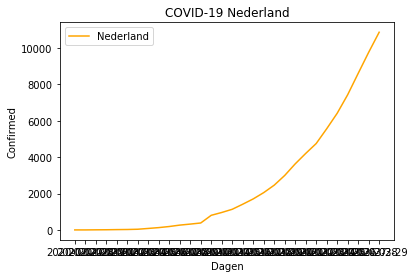

In [29]:
df_graf = df.loc[df['Region'] == 'Netherlands']
x1 = df_graf["Date"]
y1 = df_graf["Confirmed"]

plt.plot(x1,y1, color='orange', label='Nederland')
plt.title('COVID-19 '+ 'Nederland')
plt.xlabel('Dagen')
plt.ylabel('Confirmed')
plt.legend()
plt.show()

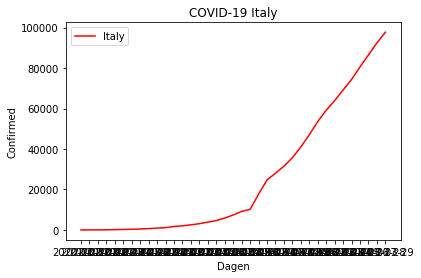

In [30]:
df_graf = df.loc[df['Region'] == 'Italy']
x1 = df_graf["Date"]
y1 = df_graf["Confirmed"]

plt.plot(x1,y1, color='red', label='Italy')
plt.title('COVID-19 '+ 'Italy')
plt.xlabel('Dagen')
plt.ylabel('Confirmed')
plt.legend()
plt.show()

Maar in de privincie Hubei, waar het coronavirus is begonnen in China, is het niet meer een exponentiele grafiek maar een sigmoid function.

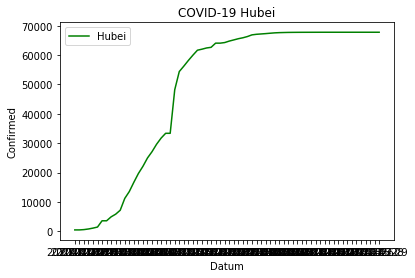

In [31]:
df_graf = df.loc[df['Region'] == 'Hubei']
x1 = df_graf["Date"]
y1 = df_graf["Confirmed"]

plt.plot(x1,y1, color='green', label='Hubei')
plt.title('COVID-19 '+ 'Hubei')
plt.xlabel('Datum')
plt.ylabel('Confirmed')
plt.legend()
plt.show()

Ik heb gekozen, omdat ik zelf ook uit Nederland kom, om aan de slag te gaan met de exponentiele grafieken.

# Epidemie model
In dit gedeelte van het notebook gaan we een voorspelling doen van de verspreiding van het coronavirus in een bepaald land. 
##### Hieronder kan je een aantal parameters instellen:

Region = voor welk land wil je een voorspelling doen? (bijvoorbeeld 'Netherlands' of 'Italy')

tijd = Voor hoeveel dagen wil je een voorspelling doen?


In [32]:
Region = 'Netherlands'
tijd = 5

In [33]:
#Nieuw dataframe aanmaken 'de_select' met alleen de data die bij het geselecteerde land horen.
df_select = df.loc[df['Region'] == Region]
#Index van df_select aanpassen naar alle datums uit de column 'Date'.
df_select.index = pd.DatetimeIndex(df_select['Date']).floor('D')
#Alle missende datums invoegen vanaf de eerste datum tot de laaste datum.
all_days = pd.date_range(df_select.index.min(), df_select.index.max(), freq='D')
df_select = df_select.loc[all_days].reset_index()
df_select = df_select.drop('Date', axis=1)
df_select = df_select.rename(columns={'index': 'Date'})
#Voor later gebruik een code aanmaken voor alle datums.
df_select['Date_code'] = pd.factorize(df_select['Date'])[0] + 1
df_select = df_select.fillna(method='ffill')
df_select

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys


,Date,Region,Confirmed,Deaths,Recovered,Date_code
0,2020-02-27,Netherlands,1.0,0.0,0.0,1
1,2020-02-28,Netherlands,1.0,0.0,0.0,2
2,2020-02-29,Netherlands,6.0,0.0,0.0,3
3,2020-03-01,Netherlands,10.0,0.0,0.0,4
4,2020-03-02,Netherlands,18.0,0.0,0.0,5
5,2020-03-03,Netherlands,24.0,0.0,0.0,6
6,2020-03-04,Netherlands,38.0,0.0,0.0,7
7,2020-03-05,Netherlands,82.0,0.0,0.0,8
8,2020-03-06,Netherlands,128.0,1.0,0.0,9
9,2020-03-07,Netherlands,188.0,1.0,0.0,10


Laten we een model maken van wat het virus in het gekozen land heeft gedaan. Het rechter getal in de 'confirmed_data' data is de R-Nought van het virus. Dit is hoe snel het virus zich kan verspreiden in dit land.

[0.0154103  3.88676277]


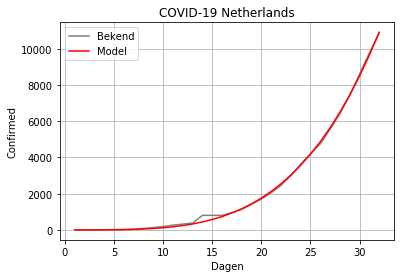

In [34]:
x_date = df_select["Date_code"]
y_confirmed = df_select["Confirmed"]

#functie definieren y=a*x tot de macht b (**)
def epidemicFunc(x,a,b):
    return a*x**b

#Covariance (confirmed_cov) is de error rate, omdat de dataset geen perfect rechte lijn geeft (niet linear).
#confirmed_data zijn a & b
confirmed_data, confirmed_cov = sp.curve_fit(epidemicFunc,x_date,y_confirmed)
print(confirmed_data)

a = confirmed_data[0]
b = confirmed_data[1]

confirmed_lin = []
for i in x_date:
    confirmed_lin.append(a*i**b)

plt.plot(x_date,y_confirmed, color='gray', label='Bekend')
plt.plot(x_date,confirmed_lin, color='red', label='Model')
plt.title('COVID-19 '+ Region)
plt.xlabel('Dagen')
plt.ylabel('Confirmed')
plt.legend()
plt.grid()
plt.show()

### Voorspelling doen voor tijd in dagen
Als laatste gaan we een voorspelling doen, voor het eerder aantal aangegeven dagen, van wat het virus gaat doen in het gekozen land.

In [35]:
toekomst_start = df_select.Date_code.max()
toekomst_einde = df_select.Date_code.max()+tijd

voorspelling_tijd = np.arange(toekomst_start, toekomst_einde+1, 1).tolist()
voorspelling = pd.DataFrame()
for dagen in voorspelling_tijd:
    confirmed_pred = epidemicFunc(dagen,a,b)
    voorspelling = voorspelling.append({'Date_code': dagen, 'Region': b, 'R_nought': b, 'Confirmed': confirmed_pred}, ignore_index=True)
voorspelling

,Confirmed,Date_code,R_nought,Region
0,10913.702376,32.0,3.886763,3.886763
1,12300.270274,33.0,3.886763,3.886763
2,13813.586286,34.0,3.886763,3.886763
3,15460.993448,35.0,3.886763,3.886763
4,17250.028851,36.0,3.886763,3.886763
5,19188.423006,37.0,3.886763,3.886763


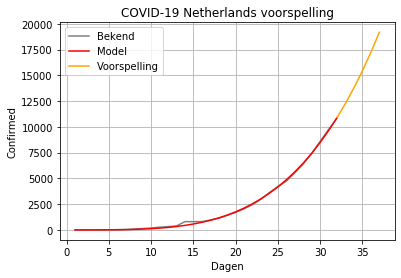

In [36]:
plt.plot(x_date,y_confirmed, color='gray', label='Bekend')
plt.plot(x_date,confirmed_lin, color='red', label='Model')
plt.plot(voorspelling["Date_code"],voorspelling["Confirmed"], color='orange', label='Voorspelling')
plt.title('COVID-19 '+ Region + ' voorspelling')
plt.xlabel('Dagen')
plt.ylabel('Confirmed')
plt.legend()
plt.grid()
plt.show()

In [37]:
voorspelling_einde = voorspelling['Confirmed'].max()
print('Over', tijd, 'dagen zullen er zoveel mensen besmet zijn met het coronavirus in', Region, ':', voorspelling_einde)

Over 5 dagen zullen er zoveel mensen besmet zijn met het coronavirus in Netherlands : 19188.42300595044
